Matrix

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.special import hankel1

In [33]:
U_values = np.arange(0, 100.05, 0.05)
m = 3.3843
Sa = 0.0859
Ia = 0.0135
rho = 1.225
c = 0.2540
b = c / 2
a = -0.5  # Fixed indentation
Kh = 2818.8
Ka = 37.8
Ch, Ca = 0, 0

Divergence speed: 78.10 m/s
Flutter speed:    18.80 m/s


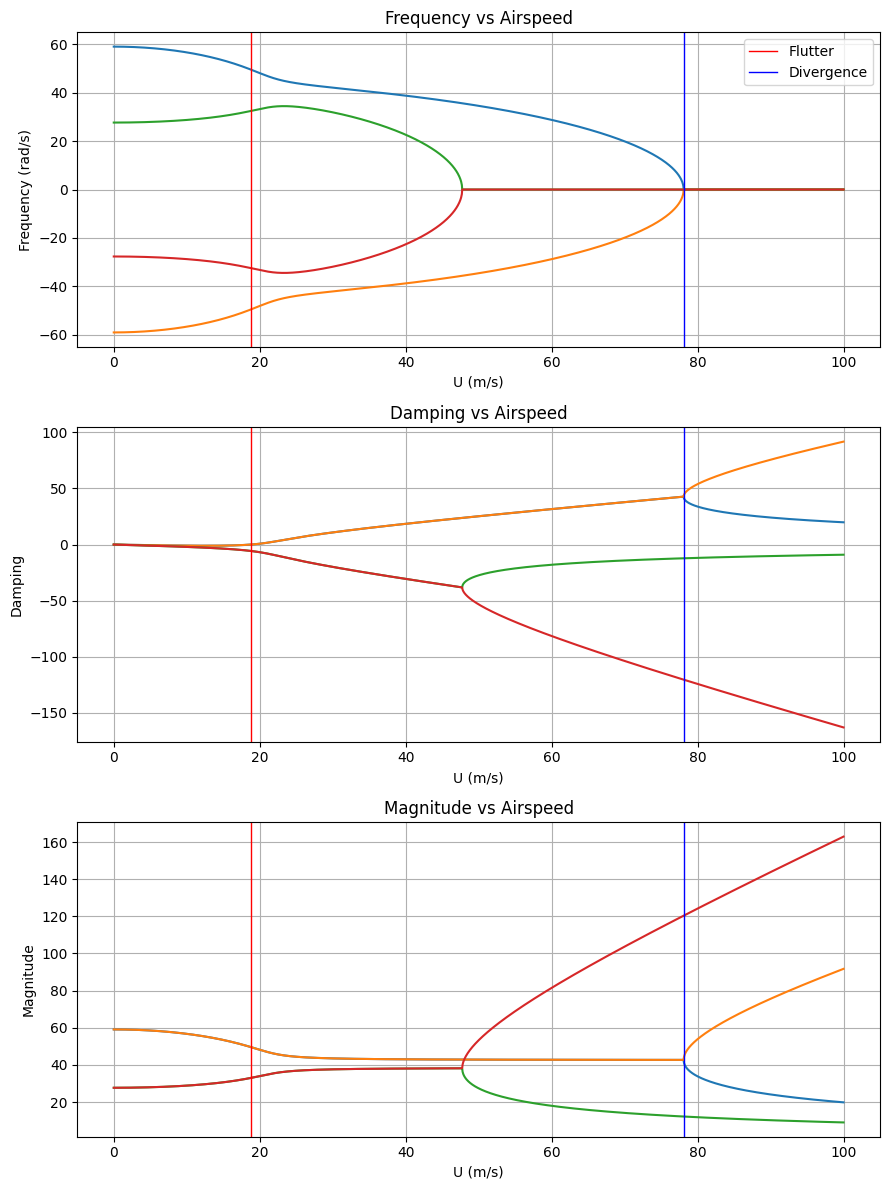

In [34]:
def flutter_analysis(M, K, C):
    n = M.shape[0]
    A = np.block([[np.zeros((n, n)), np.eye(n)],
                  [-np.linalg.solve(M, K), -np.linalg.solve(M, C)]])
    return eig(A)[0]

def sort_roots(prev, curr):
    n = len(prev)
    sorted_roots = np.zeros(n, dtype=complex)
    used = np.zeros(n, dtype=bool)
    
    for i in range(n):
        avail = np.where(~used)[0]
        distances = np.abs(prev[i] - curr[avail])
        j = np.argmin(distances)
        sorted_roots[i] = curr[avail[j]]
        used[avail[j]] = True
    return sorted_roots

def Compute_Ck(k):
    if k == 0:
        return 1
    H1 = hankel1(1, k)
    H0 = hankel1(0, k)
    return H1 / (H1 + 1j*H0)

# ========== USER INPUT ==========

num_modes = 4
roots_all = np.zeros((num_modes, len(U_values)), dtype=complex)

# ========== MAIN LOOP ==========
for i, U in enumerate(U_values):
    # Input these matrices in exam
    M = np.array([[m + np.pi*rho*b**2, Sa-np.pi*rho*b**3*a], [Sa-np.pi*rho*b**3*a, Ia+np.pi*rho*b**4*(1/8+a**2)]])
    C = np.array([[Ch + 2*np.pi*rho*b*U, np.pi*rho*b**2*U + 2*np.pi*rho*b**2*U*(0.5-a)], [-2*np.pi*rho*b**2*U*(a+0.5), Ca-2*np.pi*rho*b**3*U*(0.5-a)*(a+0.5)+np.pi*rho*b**3*U*(0.5-a)]])
    K = np.array([[Kh, 2*np.pi*rho*b*U**2], [0, Ka - 2*np.pi*rho*b**2*U**2*(a+0.5)]])
    
    lambda_ = flutter_analysis(M, K, C)
    
    if i == 0:
        roots_all[:, i] = lambda_
    else:
        roots_all[:, i] = sort_roots(roots_all[:, i-1], lambda_)

# ========== POST-PROCESSING ==========
damp = np.real(roots_all)
freq = np.imag(roots_all)
absolute = np.abs(roots_all)

flutter_speed = np.nan
divergence_speed = np.nan
tol_im = 1e-3

for i, U in enumerate(U_values):
    lam = roots_all[:, i]
    if np.any((np.real(lam) > 0) & (np.abs(np.imag(lam)) < tol_im)):
        divergence_speed = U
        break

for i, U in enumerate(U_values):
    lam = roots_all[:, i]
    if np.any((np.real(lam) > 1e-8) & (np.abs(np.imag(lam)) >= tol_im)):
        flutter_speed = U
        break

print(f'Divergence speed: {divergence_speed:.2f} m/s')
print(f'Flutter speed:    {flutter_speed:.2f} m/s')

# ========== PLOTTING ==========
plt.figure(figsize=(9, 12))

plt.subplot(3, 1, 1)
for m_idx in range(num_modes):
    plt.plot(U_values, freq[m_idx, :], linewidth=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', linewidth=1)
plt.axvline(divergence_speed, color='b', label='Divergence', linewidth=1)
plt.title('Frequency vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Frequency (rad/s)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
for m_idx in range(num_modes):
    plt.plot(U_values, damp[m_idx, :], linewidth=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', linewidth=1)
plt.axvline(divergence_speed, color='b', label='Divergence', linewidth=1)
plt.title('Damping vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Damping')
plt.grid(True)

#abs
plt.subplot(3, 1, 3)
for m_idx in range(num_modes):
    plt.plot(U_values, np.sqrt(damp[m_idx]**2 + freq[m_idx]**2), lw=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', lw=1)
plt.axvline(divergence_speed, color='b', label='Divergence', lw=1)
plt.title('Magnitude vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()

Models

Divergence speed: 39.05 m/s
Flutter speed:    6.55 m/s


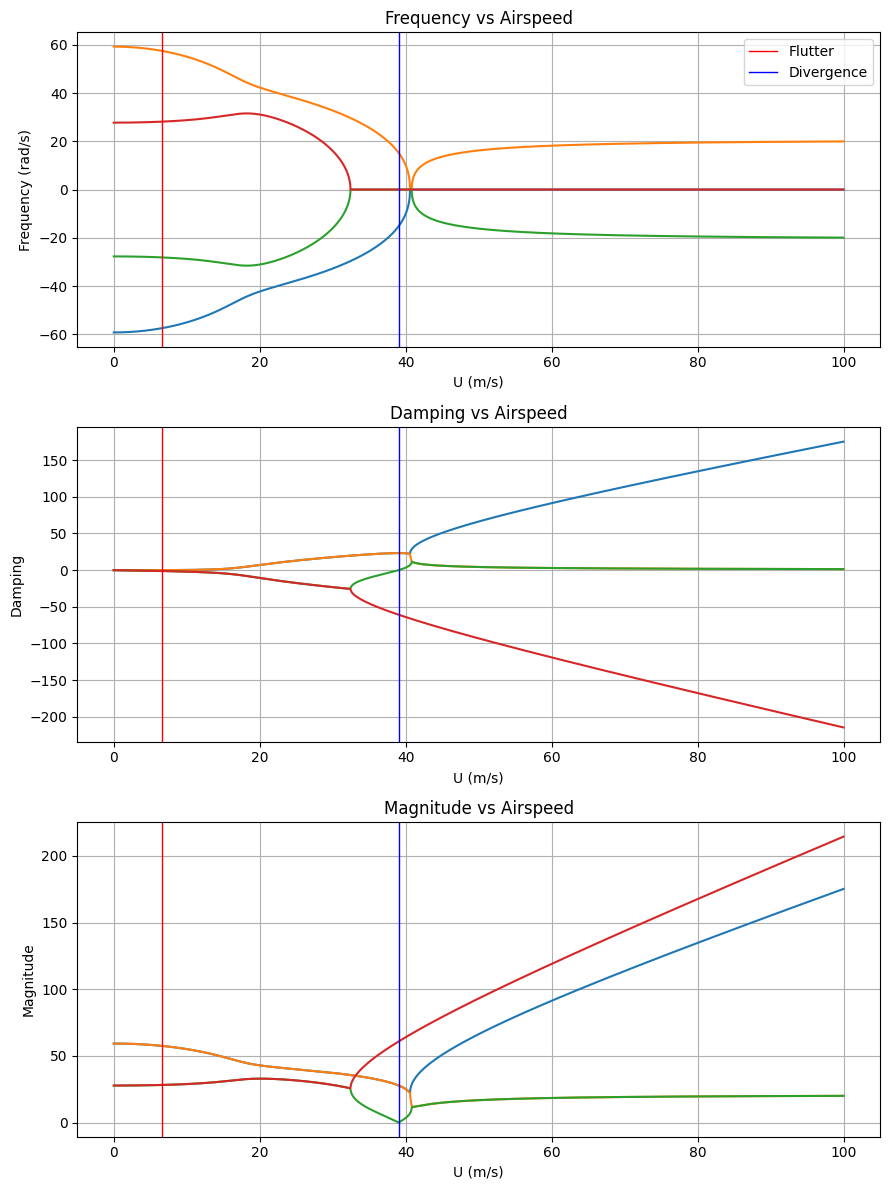

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

def flutter_analysis(M, K, C):
    n = M.shape[0]
    M_inv = np.linalg.inv(M)
    A11 = np.zeros((n, n))
    A12 = np.eye(n)
    A21 = -M_inv @ K
    A22 = -M_inv @ C
    A = np.vstack((np.hstack((A11, A12)),
                   np.hstack((A21, A22))))
    return eig(A)[0]

def sort_roots(prev, curr):
    curr = curr.copy()
    sorted_roots = np.zeros_like(prev, dtype=complex)
    used = np.zeros(len(curr), dtype=bool)
    
    for i in range(len(prev)):
        distances = np.abs(prev[i] - curr[~used])
        idx = np.argmin(distances)
        avail_idx = np.where(~used)[0][idx]
        sorted_roots[i] = curr[avail_idx]
        used[avail_idx] = True
    return sorted_roots

# ========== USER INPUT ==========
model = int(input("Enter Model number"))       # 1=quasi-static, 2=1+aero-damp, 3=quasi-steady unsteady
U = np.arange(0, 100.05, 0.05)
m = 3.3843      # plunge mass
Sa = 0.0859     # plunge-twist coupling (structural)
Ia = 0.0135     # torsional inertia
rho = 1.225     # air density
c = 0.2540      # chord
b = c/2         # semi-chord
a = -0.3        # elastic-axis offset (in chord units)
Kh = 2818.8     # plunge stiffness
Ka = 37.8       # torsional stiffness

# Structural matrices
M_struct = np.array([[m, Sa], [Sa, Ia]])
K_struct = np.array([[Kh, 0], [0, Ka]])

# Non-circulatory added mass
M_add_nc = np.pi * rho * b**2 * np.array([
    [1, -b*a],
    [-b*a, b**2*(a**2 + 1/8)]
])

# Storage arrays
num_modes = 4
roots_all = np.zeros((len(U), num_modes), dtype=complex)

# ========== MAIN ANALYSIS LOOP ==========
for i, Ui in enumerate(U):
    # Circulatory matrices
    K_circ = np.array([
        [0, 2*np.pi*rho*Ui**2*b],
        [0, -2*np.pi*rho*Ui**2*b**2*(a + 0.5)]
    ])
    
    C_circ = np.array([
        [2*np.pi*rho*Ui*b, 2*np.pi*rho*Ui*b**2*(0.5 - a)],
        [-2*np.pi*rho*Ui*b**2*(a + 0.5), 
         -2*np.pi*rho*Ui*b**3*(a + 0.5)*(0.5 - a)]
    ])
    
    C_add_nc = np.pi * rho * b**2 * np.array([
        [0, Ui],
        [0, Ui*b*(0.5 - a)]
    ])

    # Model selection
    if model == 1:
        M_curr = M_struct
        C_curr = np.zeros((2, 2))
        K_curr = K_struct + K_circ
    elif model == 2:
        M_curr = M_struct
        C_curr = C_circ
        K_curr = K_struct + K_circ
    elif model == 3:
        M_curr = M_struct + M_add_nc
        C_curr = C_circ + C_add_nc
        K_curr = K_struct + K_circ
    else:
        raise ValueError("Model must be 1, 2, or 3")

    # Eigen analysis
    lam = flutter_analysis(M_curr, K_curr, C_curr)
    
    # Root sorting
    if i == 0:
        roots_all[i] = np.sort_complex(lam)
    else:
        roots_all[i] = sort_roots(roots_all[i-1], lam)

# Transpose for consistency with MATLAB structure
roots_all = roots_all.T

# ========== POST-PROCESSING ==========
damp = np.real(roots_all)
freq = np.imag(roots_all)

# Find divergence and flutter speeds
flutter_speed = np.nan
divergence_speed = np.nan
tol_im = 1e-3

# Check for divergence (real > 0, small imaginary)
for i, u in enumerate(U):
    lam = roots_all[:, i]
    if np.any((np.real(lam) > 0) & (np.abs(np.imag(lam)) < tol_im)):
        divergence_speed = u
        break

# Check for flutter (real > 0, significant imaginary)
for i, u in enumerate(U):
    lam = roots_all[:, i]
    if np.any((np.real(lam) > 1e-8) & (np.abs(np.imag(lam)) >= tol_im)):
        flutter_speed = u
        break

print(f"Divergence speed: {divergence_speed:.2f} m/s")
print(f"Flutter speed:    {flutter_speed:.2f} m/s")

# ========== PLOTTING ==========
plt.figure(figsize=(9, 12))

# Frequency plot
plt.subplot(3, 1, 1)
for m_idx in range(num_modes):
    plt.plot(U, freq[m_idx], lw=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', lw=1)
plt.axvline(divergence_speed, color='b', label='Divergence', lw=1)
plt.title('Frequency vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Frequency (rad/s)')
plt.grid(True)
plt.legend()

# Damping plot
plt.subplot(3, 1, 2)
for m_idx in range(num_modes):
    plt.plot(U, damp[m_idx], lw=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', lw=1)
plt.axvline(divergence_speed, color='b', label='Divergence', lw=1)
plt.title('Damping vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Damping')
plt.grid(True)

#abs
plt.subplot(3, 1, 3)
for m_idx in range(num_modes):
    plt.plot(U, np.sqrt(damp[m_idx]**2 + freq[m_idx]**2), lw=1.5)
plt.axvline(flutter_speed, color='r', label='Flutter', lw=1)
plt.axvline(divergence_speed, color='b', label='Divergence', lw=1)
plt.title('Magnitude vs Airspeed')
plt.xlabel('U (m/s)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()